<a href="https://colab.research.google.com/github/YeonJungHoon/NLP-/blob/main/14th_Step(Recommend_System).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import io
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv('data.csv')
print("전체 문서의 수: {}".format(len(df)))
df.head(5)

전체 문서의 수: 2382


,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [7]:
def _removeNonAscii(s):
  return "".join(i for i in s if ord(i) < 128) #ord 함수는 문자인 인자에 해당하는 정수값을 반환한다. 

def make_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  text = text.split()
  stops = set(stopwords.words("english"))
  text = [w for w in text if w not in stops]
  text = ''.join(text)
  return text

def remove_html(text):
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r' ', text)
  
def remove_punctuation(text):
  tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
  text = tokenizer.tokenize(text)
  text = ' '.join(text)
  return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)



In [9]:
df['cleaned'][:5]

0    knowpowershifting westeastnorthsouth president...
1    followingsuccessaccidentalbillionairesmoneybal...
2    tappowersocialsoftwarenetworksbuildbusinesstru...
3    williamj bernsteinamericanfinancialtheoristneu...
4    amazingbook joinedstevejobsmanyakiomoritafancl...
Name: cleaned, dtype: object

In [12]:
df['cleaned'].replace('', np.nan, inplace = True)
df = df[df['cleaned'].notna()]
print("전체 문서의 수: {}".format(len(df)))

전체 문서의 수: 2381


In [14]:
corpus = [word.split() for word in df['cleaned']]
corpus[:2]

[['knowpowershifting',
  'westeastnorthsouth',
  'presidentialpalacespublicsquares',
  'formidablecorporatebehemothsnimblestartupsand',
  'slowlysurely',
  'menwomen',
  'powermerelyshiftingdispersing',
  'alsodecaying',
  'powertodayconstrainedrisklosingeverbefore',
  'endpower',
  'award',
  'winningcolumnistformerforeignpolicyeditormoissnamilluminatesstruggleonce',
  'dominantmegaplayersnewmicropowerschallengingeveryfieldhumanendeavor',
  'drawingprovocative',
  'originalresearch',
  'namshowsantiestablishmentdrivemicropowerstoppletyrants',
  'dislodgemonopolies',
  'openremarkablenewopportunities',
  'alsoleadchaosparalysis',
  'namdeftlycoversseismicchangesunderwaybusiness',
  'religion',
  'education',
  'withinfamilies',
  'matterswarpeace',
  'examplesaboundwalkslife',
  'eighty',
  'ninecountriesruledautocratstodayhalfworld',
  'spopulationlivesdemocracies',
  'ceo',
  'sconstrainedshortertenurespredecessors',
  'moderntoolswar',
  'cheaperaccessible',
  'makepossiblegroupslik

#Pre-trained-Word2Vec

In [16]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(size = 300, window =5, min_count = 2 , workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf = 1.0, binary = True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)


(0, 0)

In [30]:
def get_document_vectors(document_list):
  document_embedding_list = []
  
  for line in document_list:
    doc2vec = None
    count = 0
    for word in line.split():
      if word in word2vec_model.wv.vocab:
        count +=1

        if doc2vec is None:
          doc2vec = word2vec_model[word]
        else:
          doc2vec = doc2vec + word2vec_model[word]

    if doc2vec is not None:
      doc2vec = doc2vec/count
      document_embedding_list.append(doc2vec)

  return document_embedding_list


document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수: {}'.format(len(document_embedding_list)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


문서 벡터의 수: 2238


In [32]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기: {}'.format(cosine_similarities.shape))

def recommendations(title):
  books = df[['title', 'image_link']]
  
  indices = pd.Series(df.index, index = df['title']).drop_duplicates()
  idx = indices[title]
  
  sim_scores = list(enumerate(cosine_similarities[idx]))
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
  sim_scores = sim_scores[1:6]
  
  book_indices = [i[0] for i in sim_scores]

  recommend = books.iloc[book_indices].reset_index(drop = True)

  fig = plt.figure(figsize = (20,30))

  for index, row in recommend.iterrows():
    response = requests.get(row['image_link'])
    img = Image.open(io.BytesIO(response.content))
    fig.add_subplot(1,5,index + 1)
    plt.imshow(img)
    plt.title(row['title'])

코사인 유사도 매트릭스의 크기: (2238, 2238)


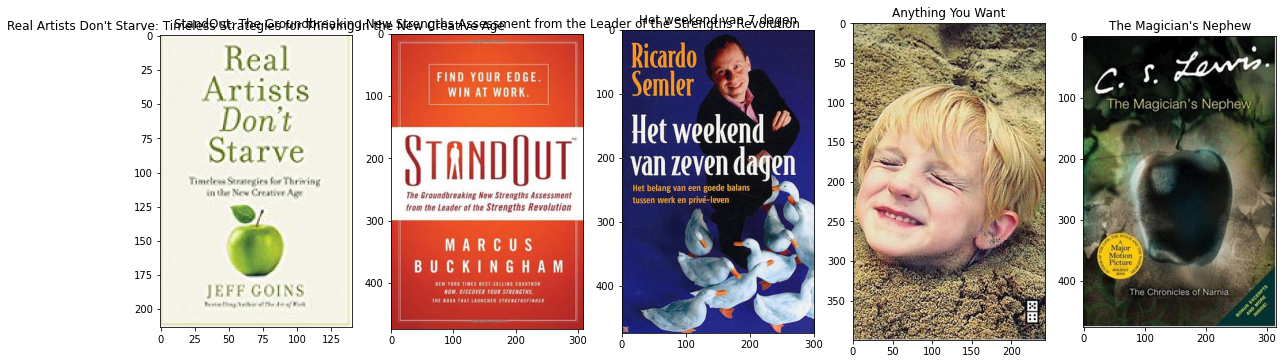

In [33]:
recommendations('The Da Vinci Code')

#워드 임베딩의 평균 = 문장 임베딩 벡터

In [34]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [35]:
vocab_size = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)
print("훈련용 리뷰 개수: {}".format(len(X_train)))
print("테스트용 리뷰 개수: {}".format(len(X_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수: 25000
테스트용 리뷰 개수: 25000


In [36]:
print("훈련용 리뷰의 평균 길이: {}".format(np.mean(list(map(len, X_train)), dtype = int)))
print("테스트용 리뷰의 평균 길이: {}".format(np.mean(list(map(len, X_test)), dtype = int)))


훈련용 리뷰의 평균 길이: 238
테스트용 리뷰의 평균 길이: 230


In [37]:
max_len = 400

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
print("X_train의 크기:{}".format(X_train.shape))
print("X_test의 크기: {}".format(X_test.shape))

X_train의 크기:(25000, 400)
X_test의 크기: (25000, 400)


In [38]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size , embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4 )
mc = ModelCheckpoint('embedding_average_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.fit(X_train, y_train, batch_size = 32, epochs = 10, callbacks = [es, mc], validation_split = 0.2)


Epoch 1/10
617/625 [============================>.] - ETA: 0s - loss: 0.6319 - acc: 0.7199
Epoch 1: val_acc improved from -inf to 0.81860, saving model to embedding_average_model.h5
625/625 [==============================] - 9s 9ms/step - loss: 0.6306 - acc: 0.7213 - val_loss: 0.5237 - val_acc: 0.8186
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.4313 - acc: 0.8573
Epoch 2: val_acc improved from 0.81860 to 0.86180, saving model to embedding_average_model.h5
625/625 [==============================] - 5s 9ms/step - loss: 0.4312 - acc: 0.8574 - val_loss: 0.3840 - val_acc: 0.8618
Epoch 3/10
619/625 [============================>.] - ETA: 0s - loss: 0.3196 - acc: 0.8910
Epoch 3: val_acc improved from 0.86180 to 0.88040, saving model to embedding_average_model.h5
625/625 [==============================] - 6s 9ms/step - loss: 0.3193 - acc: 0.8910 - val_loss: 0.3232 - val_acc: 0.8804
Epoch 4/10
623/625 [============================>.] - ETA: 0s - loss: 0.2618 - acc: 0

In [41]:
loaded_model = load_model('embedding_average_model.h5')
print("테스트의 정확도: {} %".format(int(loaded_model.evaluate(X_test, y_test)[1] * 100)))

782/782 [==============================] - 2s 3ms/step - loss: 0.2890 - acc: 0.8856
테스트의 정확도: 88 %
